## 185. Department Top Three Salaries


**Change Log**   

| Date | Description |
| ---------- | ---------- |
| 2022-04-11 | Initialize |



## Summary

Find all employees whose salary is in the top three salaries for their department.

#### SQL Schema

```sql
Create table If Not Exists Employee (id int, name varchar(255), salary int, departmentId int)
Create table If Not Exists Department (id int, name varchar(255))
Truncate table Employee
insert into Employee (id, name, salary, departmentId) values ('1', 'Joe', '85000', '1')
insert into Employee (id, name, salary, departmentId) values ('2', 'Henry', '80000', '2')
insert into Employee (id, name, salary, departmentId) values ('3', 'Sam', '60000', '2')
insert into Employee (id, name, salary, departmentId) values ('4', 'Max', '90000', '1')
insert into Employee (id, name, salary, departmentId) values ('5', 'Janet', '69000', '1')
insert into Employee (id, name, salary, departmentId) values ('6', 'Randy', '85000', '1')
insert into Employee (id, name, salary, departmentId) values ('7', 'Will', '70000', '1')
Truncate table Department
insert into Department (id, name) values ('1', 'IT')
insert into Department (id, name) values ('2', 'Sales')

```

Table: Employee

```
+--------------+---------+
| Column Name  | Type    |
+--------------+---------+
| id           | int     |
| name         | varchar |
| salary       | int     |
| departmentId | int     |
+--------------+---------+
id is the primary key column for this table.
departmentId is a foreign key of the ID from the Department table.
Each row of this table indicates the ID, name, and salary of an employee. It also contains the ID of their department.
```

Table: Department

```
+-------------+---------+
| Column Name | Type    |
+-------------+---------+
| id          | int     |
| name        | varchar |
+-------------+---------+
id is the primary key column for this table.
Each row of this table indicates the ID of a department and its name.
```

## Problem

A company's executives are interested in seeing who earns the most money in each of the company's departments. A **high earner** in a department is an employee who has a salary in the **top three unique** salaries for that department.

Write an SQL query to find the employees who are **high earners** in each of the departments.

Return the result table in **any order**.

The query result format is in the following example.

 

#### Example 1:

**Input:** 
```
Employee table:
+----+-------+--------+--------------+
| id | name  | salary | departmentId |
+----+-------+--------+--------------+
| 1  | Joe   | 85000  | 1            |
| 2  | Henry | 80000  | 2            |
| 3  | Sam   | 60000  | 2            |
| 4  | Max   | 90000  | 1            |
| 5  | Janet | 69000  | 1            |
| 6  | Randy | 85000  | 1            |
| 7  | Will  | 70000  | 1            |
+----+-------+--------+--------------+
Department table:
+----+-------+
| id | name  |
+----+-------+
| 1  | IT    |
| 2  | Sales |
+----+-------+
```
**Output:**
```
+------------+----------+--------+
| Department | Employee | Salary |
+------------+----------+--------+
| IT         | Max      | 90000  |
| IT         | Joe      | 85000  |
| IT         | Randy    | 85000  |
| IT         | Will     | 70000  |
| Sales      | Henry    | 80000  |
| Sales      | Sam      | 60000  |
+------------+----------+--------+
```

**Explanation**:  
In the IT department:
- Max earns the highest unique salary
- Both Randy and Joe earn the second-highest unique salary
- Will earns the third-highest unique salary

In the Sales department:
- Henry earns the highest salary
- Sam earns the second-highest salary
- There is no third-highest salary as there are only two employees

--- 

### Discussion

The initial thought is to extend the logic we used in Problem 184 (Department Highest Salary) by adding a `TOP 3` clause. This will not work because this will only three (3) rows for the first departmentId the query selects.  

So following does not work:
```sql
SELECT      TOP 3
            departmendId
            , MAX(salary)
FROM        Employee
GROUP BY    departmentId
```

That leaves us with trying to find another method.  We might get some insight by stepping back and thinking about how we would manually do this.  Logically we would:
- do some kind of grouping (**partitioning**) by department
- then **rank** the salaries from highest to lowest
- then select the first three ranks for each department

There are a few clues in there.  We might be able to use the `RANK()` or `DENSE_RANK()` functions.  Upon reviewing those we note that `RANK()` will skip if there is a tie, where `DENSE_RANK()` does not.  This can be seen in the output below.

#### Assuming:
```sql
SELECT  departmentId
        , salary
        , RANK() OVER (PARTITION BY departmentId ORDER BY salary DESC) AS R
        , DENSE_RANK() OVER(PARTITION BY departmentId ORDER BY salary DESC) AS DR
FROM    Employee
```



| departmentId | salary  | R | DR |
| ---- | ------- | ---- | ---- |
| 1 | 90000 | 1 | 1 | 
| 1 | 85000 | 2 | 2 |
| 1 | 85000 | 2 | 2 |
| 1 | 70000 | 4 | 3 |
| 1 | 69000 | 5 | 4 |
| 2 | 80000 | 1 | 1 |
| 2 | 60000 | 2 | 2 |
| ---- | ------- | ---- | ---- |


`DENSE_RANK()` gives us the expected behavior that we want.  The type three salaries for department 1 are 90000, 85000, and 70000.  We do not want omit the 70000 records because three or more employees have the top two salaries.

It looks like `DENSE_RANK()` is exactly what we need.  All that we have to do now is:
- join to the `Employee` table on `departmentId` and `salary`
- join to the `Department` table on `departmentId`
- filter to only return records with a **rank < 4**  (or <=3)

***Let's Get To It!!***


--- 

## Solution 1 - MSSQL - Use DENSE_RANK() In a Sub-Query

#### The Plan:
Use the above as a subquery to get the `Employee` records and `Department` records.



**Testing code**
```sql
/* Write your T-SQL query statement below */
SELECT      d.name                  AS Department
            , e.name                AS Employee
            , e.salary
            ,'----'                 AS Sep
            , ranks.departmentId    AS rankDeptId
            , ranks.salary          AS rankSalary
            , ranks.DR              AS rankDR
FROM        Employee e
            JOIN Department d ON d.id = e.departmentId
            JOIN (
                SELECT  departmentId
                        , salary
                        , DENSE_RANK() OVER(PARTITION BY departmentId ORDER BY salary DESC) AS DR
                FROM    Employee e
                GROUP BY departmentId, salary
            ) AS ranks ON ranks.departmentId = e.departmentId
                      AND ranks.salary = e.salary
WHERE       ranks.DR < 4

```

**Final Code**
```sql
/* Write your T-SQL query statement below */
SELECT      d.name                  AS Department
            , e.name                AS Employee
            , e.salary
FROM        Employee e
            JOIN Department d ON d.id = e.departmentId
            JOIN (
                SELECT  departmentId
                        , salary
                        , DENSE_RANK() OVER(PARTITION BY departmentId ORDER BY salary DESC) AS DR
                FROM    Employee e
                GROUP BY departmentId, salary
            ) AS ranks ON ranks.departmentId = e.departmentId
                      AND ranks.salary = e.salary
WHERE       ranks.DR < 4

```

### Result

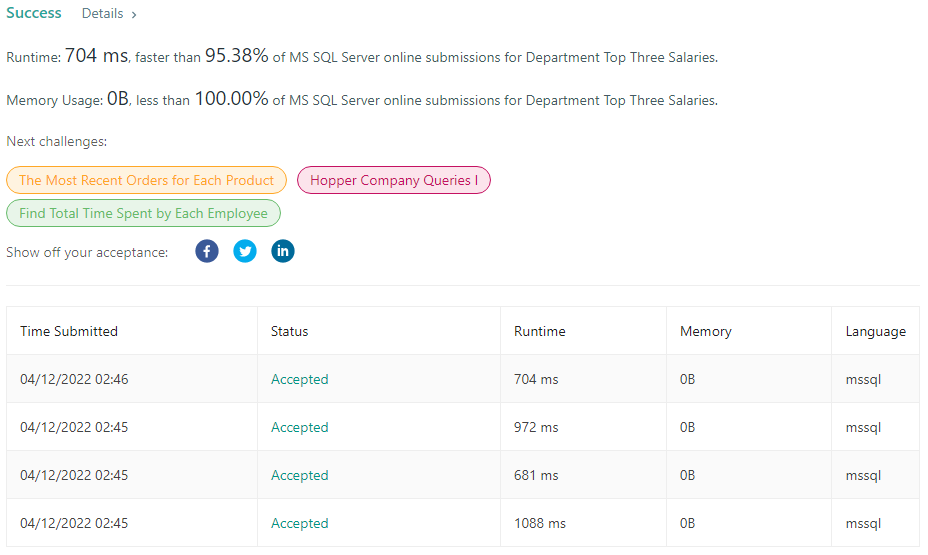



The results are good, but as we noted before server load has a big impact on variation.

--- 

## Solution 2 - MSSQL - Use Join to SubQuery





```sql
/* Write your T-SQL query statement below */


SELECT      d1.Name           AS Department
            , e1.Name         AS Employee
            , e1.Salary       AS Salary
FROM        Employee e
            JOIN Department d ON d.Id = e.Id
WHERE       3 > (
                    SELECT  count(distinct(e2.salary)) 
                    FROM    Employee e2 
                    WHERE   e2.salary > e.salary 
                            AND e2.DepartmentId = e.DepartmentId
                )


```

### Result

#### << NOT DONE >>
![image.png]()



No noticeable difference on a dataset this small

--- 

## Solution 3 - MySQL 

Pretty much the same thing in MySQL. 

```sql
# Write your MySQL query statement below

;

```



### Result






As usual MySQL is kicking butt on MSSQL.

--- 
